## Initial Setup

Analysis done only for the folder 20250105_082554.

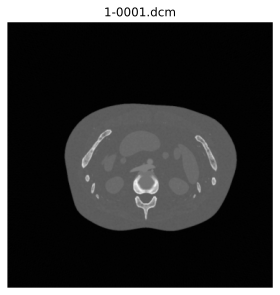

In [1]:
import os
import pydicom
import matplotlib.pyplot as plt

# Relative path - parent folder has data folder and repo folder
dicom_folder = "../20250105_082554/20250105_082554/LIDC-IDRI/LIDC-IDRI-0000/01-01-2000-NA-NA-02587/923375.000000-NA-30179"

dicom_files = [f for f in os.listdir(dicom_folder) if f.endswith(".dcm")]

for file in dicom_files:
    filepath = os.path.join(dicom_folder, file)
    ds = pydicom.dcmread(filepath)
    plt.imshow(ds.pixel_array, cmap='gray')
    plt.title(f"{file}")
    plt.axis('off')
    plt.show()
    break  


In [2]:
import glob

# Base folder path 
base_path = "../20250105_082554/20250105_082554/LIDC-IDRI"

# Get all patient folders (e.g., LIDC-IDRI-0000, LIDC-IDRI-0001, ...)
patient_folders = [os.path.join(base_path, d) for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

json_paths = []

for patient_folder in patient_folders:
    # Go 2 levels deep using glob
    json_files = glob.glob(os.path.join(patient_folder, "*", "*", "*.json"))
    if json_files:
        json_paths.append(json_files[0])  # Assuming only one json per patient

print(json_paths[0])


../20250105_082554/20250105_082554/LIDC-IDRI\LIDC-IDRI-0000\01-01-2000-NA-NA-02587\923375.000000-NA-30179\segmentation_00000.json


## Preparing Radiomics Data

In [3]:
benign = [
    "Granuloma", "Active Infection", "Sarcoidosis", "Hamartoma",
    "Bronchioloalveolar Hyperplasia", "Long Covid", "Intrapulmonary Lymph Nodes"
]

malignant = [
    "Adenocarcinoma", "Squamous Cell Carcinoma", "Large Cell (Undifferentiated) Carcinoma",
    "Small Cell Lung Cancer (SCLC)", "Carcinoid Tumors", "Sarcomatoid Carcinoma",
    "Lymphoma", "Adenoid Cystic Carcinoma", "Metastatic Tumors"
]

def classify_nodule_type(name):
    if name in benign:
        return "Benign"
    elif name in malignant:
        return "Malignant"
    else:
        return "Unknown"  


In [4]:
import json
import pandas as pd

all_data = []

for file in json_paths:
    with open(file, "r") as f:
        data = json.load(f)

    characteristics = data.get("characteristics", [])
    slice_thickness = data.get("slice_thickness", None)
    annotations = data.get("annotation", [])

    slice_numbers = []
    for ann in annotations:
        if isinstance(ann, dict):
            slice_numbers.extend(map(int, ann.keys()))
    slice_numbers = sorted(set(slice_numbers))  # remove duplicates + sort


    for char in characteristics:
        nodule_name = char.get("nodule_name")
        row = {
            "nodule_name": nodule_name,
            "nodule_category": classify_nodule_type(nodule_name),
            "calcification": char.get("calcification"),
            "internal_structure": char.get("internal_structure"),
            "lobulation": char.get("lobulation"),
            "margin": char.get("margin"),
            "nodule_type": char.get("nodule_type"),
            "sphericity": char.get("sphericity"),
            "texture": char.get("texture"),
            "global_seed": char.get("global_seed"),
            "slice_thickness": slice_thickness,
            "slices_present": slice_numbers,
            "file_path": file
        }
        all_data.append(row)

df = pd.DataFrame(all_data)



Some nodules as named as "Hyperplasia" instead of "Bronchioloalveolar Hyperplasia"

In [5]:
df["nodule_name"] = df["nodule_name"].replace("Hyperplasia", "Bronchioloalveolar Hyperplasia")

Some nodules are named "Granuloma - Active Infection". Renaming it to just "Active Infection"

In [6]:
df["nodule_name"] = df["nodule_name"].replace("Granuloma - Active Infection", "Active Infection")

Since both of them are benign nodules, replace their category from "Unknown" to "Benign"

In [7]:
df["nodule_category"] = df["nodule_category"].replace("Unknown", "Benign")

In [8]:
df[:5]

,nodule_name,nodule_category,calcification,internal_structure,lobulation,margin,nodule_type,sphericity,texture,global_seed,slice_thickness,slices_present,file_path
0,Adenoid Cystic Carcinoma,Malignant,Absent,Soft Tissue,None-M,Poo-Sh,m8,Ovoid,Part Solid/Mixed,7454.7391,2.50,"[52, 53, 54, 55, 56]",../20250105_082554/20250105_082554/LIDC-IDRI\L...
1,Carcinoid Tumors,Malignant,Absent,Soft Tissue,Nn-Mk,P-Sharp,m5,Ov-Ro,Solid,20538.7077,2.50,"[43, 44, 45]",../20250105_082554/20250105_082554/LIDC-IDRI\L...
2,Sarcomatoid Carcinoma,Malignant,Absent,Soft Tissue,Nn-Mk,Poorly,m6,Lin-Ov,Part Solid/Mixed,20133.7427,2.50,"[53, 54, 55, 56]",../20250105_082554/20250105_082554/LIDC-IDRI\L...
3,Bronchioloalveolar Hyperplasia,Benign,Absent,Soft Tissue,Nn-Mk,Poorly-S,b5,Ov-Ro,NS-PS,444.1777,1.25,"[44, 45, 46, 47, 48, 49]",../20250105_082554/20250105_082554/LIDC-IDRI\L...
4,Metastatic Tumors,Malignant,Absent,Soft Tissue,None,Sharp,m9,Ov-Ro,Solid,19244.0979,2.50,"[17, 18, 19]",../20250105_082554/20250105_082554/LIDC-IDRI\L...


In [9]:
df.to_csv("nodule_summary.csv", index=False)

## Exploratory Data Analysis

In [10]:
print("Total nodules:", len(df))

Total nodules: 186


In [11]:
from collections import defaultdict

grouped_counts = defaultdict(list)

name_counts = df["nodule_name"].value_counts()

for name, count in name_counts.items():
    category = classify_nodule_type(name)
    grouped_counts[category].append((name, count))

for category in ["Benign", "Malignant", "Unknown"]:
    if grouped_counts[category]:
        print(f"\n{category}:")
        for i, (name, count) in enumerate(grouped_counts[category], 1):
            print(f"{i}. {name} - {count}")



Benign:
1. Granuloma - 27
2. Bronchioloalveolar Hyperplasia - 25
3. Sarcoidosis - 19
4. Hamartoma - 12
5. Active Infection - 11
6. Intrapulmonary Lymph Nodes - 7

Malignant:
1. Lymphoma - 18
2. Large Cell (Undifferentiated) Carcinoma - 13
3. Small Cell Lung Cancer (SCLC) - 13
4. Metastatic Tumors - 9
5. Adenoid Cystic Carcinoma - 8
6. Squamous Cell Carcinoma - 7
7. Adenocarcinoma - 7
8. Carcinoid Tumors - 5
9. Sarcomatoid Carcinoma - 5


NOTE: Long Covid is not relevant to our study, hence it is not present in our dataset

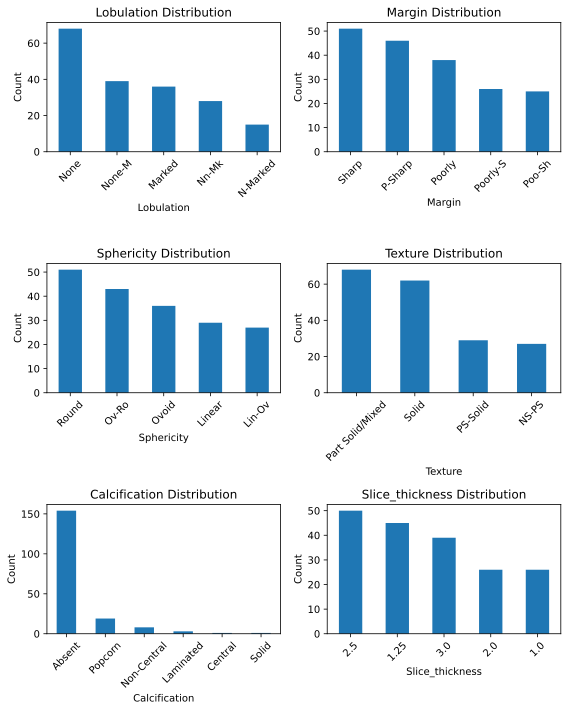

In [12]:
import matplotlib.pyplot as plt

features = ["lobulation", "margin", "sphericity", "texture", "calcification", "slice_thickness"]

fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes = axes.flatten()  

for i, feature in enumerate(features):
    df[feature].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"{feature.capitalize()} Distribution")
    axes[i].set_xlabel(feature.capitalize())
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.show()


What do these x-axis values mean??

In [13]:
from pprint import pprint

feature_counts = {}

for feature in features:
    counts = df[feature].value_counts().to_dict()
    feature_counts[feature] = counts

pprint(feature_counts)

{'calcification': {'Absent': 154,
                   'Central': 1,
                   'Laminated': 3,
                   'Non-Central': 8,
                   'Popcorn': 19,
                   'Solid': 1},
 'lobulation': {'Marked': 36,
                'N-Marked': 15,
                'Nn-Mk': 28,
                'None': 68,
                'None-M': 39},
 'margin': {'P-Sharp': 46,
            'Poo-Sh': 25,
            'Poorly': 38,
            'Poorly-S': 26,
            'Sharp': 51},
 'slice_thickness': {1.0: 26, 1.25: 45, 2.0: 26, 2.5: 50, 3.0: 39},
 'sphericity': {'Lin-Ov': 27,
                'Linear': 29,
                'Ov-Ro': 43,
                'Ovoid': 36,
                'Round': 51},
 'texture': {'NS-PS': 27, 'PS-Solid': 29, 'Part Solid/Mixed': 68, 'Solid': 62}}


In [14]:
df["internal_structure"].value_counts()

internal_structure
Soft Tissue    186
Name: count, dtype: int64

## Creating a 17th class - Normal

In [15]:
import random

NUM_SAMPLES = 25

# Step 1: Get all patient folders
patient_dirs = [os.path.join(base_path, d) for d in os.listdir(base_path) if d.startswith("LIDC-IDRI")]

# Step 2: Randomly sample 25 folders
selected_patients = random.sample(patient_dirs, min(NUM_SAMPLES, len(patient_dirs)))

# Step 3: Flatten all slices_present from df into a single set
used_slices = set()
for slices in df["slices_present"]:
    used_slices.update(slices)

# Step 4: Collect new normal samples
normal_rows = []

for patient_path in selected_patients:
    scan_folders = []
    for root, dirs, files in os.walk(patient_path):
        if any(f.endswith('.dcm') for f in files):
            scan_folders.append(root)

    if not scan_folders:
        continue

    # Randomly pick one scan folder
    scan_folder = random.choice(scan_folders)
    dicom_files = [f for f in os.listdir(scan_folder) if f.endswith('.dcm')]

    available_instances = []
    for f in dicom_files:
        dicom_path = os.path.join(scan_folder, f)
        try:
            dcm = pydicom.dcmread(dicom_path, stop_before_pixels=True)
            instance = dcm.get("InstanceNumber", None)
            if instance is not None and instance not in used_slices:
                available_instances.append((instance, dicom_path))
        except:
            continue

    if not available_instances:
        continue

    # Pick one normal slice
    chosen_instance, _ = random.choice(available_instances)

    normal_rows.append({
        "nodule_name": "No nodule",
        "nodule_category": "Normal",
        "calcification": None,
        "internal_structure": None,
        "lobulation": None,
        "margin": None,
        "nodule_type": None,
        "sphericity": None,
        "texture": None,
        "global_seed": None,
        "slice_thickness": None,
        "slices_present": [int(chosen_instance)],
        "file_path": scan_folder
    })

print(f" Collected {len(normal_rows)} normal samples.")

normal_df = pd.DataFrame(normal_rows)
df = pd.concat([df, normal_df], ignore_index=True)


 Collected 25 normal samples.


In [16]:
df["nodule_category"].value_counts()

nodule_category
Benign       101
Malignant     85
Normal        25
Name: count, dtype: int64

In [18]:
df.to_csv("training_data.csv", index=False)

212 samples if too less for training!